<H1>Overview</H1>

The Passenger Screening Algorithm Challenge asks the data science community to assist with improving threat detection at US airports while minimizing false positives to avoid long lines and delays. (Can I get an amen!).  This notebook is a follow up to my first effort for this contest called [Exploratory Data Analysis and Example Generation](https://www.kaggle.com/jbfarrar/exploratory-data-analysis-and-example-generation) (I'll call it EDA from now on).  As I mentioned in the EDA notebook, the HD-AIT system files supplied in this contest range from 10MB to approximately 2GB per subject.  In the instructions, the organizers suggest that one may even be able to win the contest with one of the smaller image suites. In that notebook, in addition to a review of the data and its vagueries, I supplied some basic building blocks for a preprocessing pipeline.

In this notebook, I continue the series with a full preprocessing pipeline using the building blocks from before as well as a first pass through a CNN based on the Alexnet using Tensorflow.  Clearly, no one is going to win the contest with this method, but I thought it would be helpful to everyone working on this to have an end to end working pipeline.  I hope you find it useful, and if you do, I hope you'll give me an up vote!

As previously noted, I'm not an expert on these systems or the related scans.  If you see something I've misunderstood or you think I've made an error, let me know and I'll correct it.  TSA has made it harder for people to get into this contest by disallowing even masked images to be protrayed on Kaggle, so you'll have to put these scripts in your own environment to take them around the track.  In any event, I am convinced that data science can improve the predictive veracity of these scans.  I'll get off the soap box now and move on.

To begin I collect all of the imports used in the notebook at the top.  It makes it easier when you're converting to a preprocessing script.  Make sure to take note of the last import, tsahelper. You will need to install tsahelper and uncomment this line in order for this pipeline to work. The tsahelper package is made from the EDA and is now available as a pip install (no warranties!). 


In [1]:
# import libraries
from __future__ import print_function
from __future__ import division

import numpy as np 
import pandas as pd
import os
import re

import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization

import random
from timeit import default_timer as timer

import tsahelper as tsa

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/numpy/core/machar.py:127: RuntimeWarning: overflow encountered in add
  a = a + a
/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/numpy/core/machar.py:129: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/numpy/core/machar.py:138: RuntimeWarning: invalid value encountered in subtract
  itemp = int_conv(temp-a)
/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/numpy/core/machar.py:162: RuntimeWarning: overflow encountered in add
  a = a + a
/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/numpy/core/machar.py:164: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/numpy/core/machar.py:171: RuntimeWarning: invalid value encountered in subtract
  if any(temp-a != zero):


Here I collect the constants all in one place.  Once you are running training routinely, you'll want it to be easy to try different parameters. One tricky thing about the preprocessing approach employed here, is determining when a mini batch is complete.  There are 182 views of the threat zones per subject (more on the terminology and approach for this covered in detail in the [EDA](https://www.kaggle.com/jbfarrar/exploratory-data-analysis-and-example-generation)), so the batch counts depend on this fact to know when we have a complete minibatch.  Note also that FILE_LIST, TRAIN_FILE_LIST, and TEST_FILE_LIST are empty until after preprocessing.  More on that below.

In [22]:
#---------------------------------------------------------------------------------------
# Constants
#
# INPUT_FOLDER:                 The folder that contains the source data
#
# PREPROCESSED_DATA_FOLDER:     The folder that contains preprocessed .npy files 
# 
# STAGE1_LABELS:                The CSV file containing the labels by subject
#
# THREAT_ZONE:                  List of threat zones to train on (actual number not 0 based)
#
# BATCH_SIZE:                   Number of Subjects per batch
#
# EXAMPLES_PER_SUBJECT          Number of examples generated per subject
#
# FILE_LIST:                    A list of the preprocessed .npy files to batch
# 
# TRAIN_TEST_SPLIT_RATIO:       Ratio to split the FILE_LIST between train and test
#
# TRAIN_SET_FILE_LIST:          The list of .npy files to be used for training
#
# TEST_SET_FILE_LIST:           The list of .npy files to be used for testing
#
# IMAGE_DIM:                    The height and width of the images in pixels
#
# LEARNING_RATE                 Learning rate for the neural network
#
# N_TRAIN_STEPS                 The number of train steps (epochs) to run
#
# TRAIN_PATH                    Place to store the tensorboard logs
#
# MODEL_PATH                    Path where model files are stored
#
# MODEL_NAME                    Name of the model files
#
#----------------------------------------------------------------------------------------
INPUT_FOLDER = '../../../dataset/a3daps/'
PREPROCESSED_DATA_FOLDER = '../../../dataset/preprocessed-a3daps/'
STAGE1_LABELS = 'stage1_labels.csv'
THREAT_ZONE = [i+1 for i in range(17)]
BATCH_SIZE = 16
EXAMPLES_PER_SUBJECT = 182

FILE_LIST = []
TRAIN_TEST_SPLIT_RATIO = 0.2
TRAIN_SET_FILE_LIST = []
TEST_SET_FILE_LIST = []

IMAGE_DIM = 250
LEARNING_RATE = 1e-3
N_TRAIN_STEPS = 1
TRAIN_PATH = 'model_output/train/'
MODEL_PATH = 'model_output/model/'
MODEL_NAME = ('tsa-{}-lr-{}-{}-{}-tz-{}'.format('alexnet-v0.1', LEARNING_RATE, IMAGE_DIM, 
                                                IMAGE_DIM, THREAT_ZONE )) 


<H3>The Preprocessor</H3>

Throughout this notebook, passengers who are being scanned for contraband are referred to as "subjects".  The preprocessor begins with 3 different ways you can choose to read in a list of subjects.  If you are training on the full data set, OPTION 1 (see the comments) is your best bet.  If you want to preprocess all subjects for whom you have data, then OPTION 2 is your best choice, and if you are running in a sample or low volume notebook environment, then you can just give a short list of subject IDs for whom you have data loaded using OPTION 3.

My approach in this notebook is to isolate each individual threat zone from every visible angle and then make features out of each individual threat zone from each angle that a given threat zone is visible. This allows us to train on each threat zone individually from every view in a 2D format.  (This is covered in some detail in the [EDA](https://www.kaggle.com/jbfarrar/exploratory-data-analysis-and-example-generation)).

The preprocessor loops through the data one subject at a time, transforms the images, isolates threat zones, and uses a set of vertices to crop each image to 250x250.  Images are saved in minibatches by threat zone, so that they can be read into the trainer.

Note that the trainer depends upon the threat zone number being present in the minibatch file name.  (Not my favorite approach, but it was fastest and easiest given what I was doing).  If you have a better idea, pass it along!

In [23]:
labels_df = pd.read_csv(STAGE1_LABELS)

# Separate the zone and subject id into a labels_df
labels_df['Subject'], labels_df['Zone'] = labels_df['Id'].str.split('_',1).str
labels_df = labels_df[['Subject', 'Zone', 'Probability']]
labels_df = labels_df.sort_values('Probability', ascending=False)
labels_df.Zone = labels_df.Zone.str.replace('Zone','').astype(int)
labels_df.Probability = labels_df.Probability.astype(int)
labels_df = labels_df.sort_values(['Subject', 'Zone'])

In [24]:
#---------------------------------------------------------------------------------------
# preprocess_tsa_data(): preprocesses the tsa datasets
#
# parameters:      none
#
# returns:         none
#---------------------------------------------------------------------------------------

def preprocess_tsa_data():
    
    # OPTION 1: get a list of all subjects for which there are labels
    SUBJECT_LIST = labels_df['Subject'].unique()

    # OPTION 2: get a list of all subjects for whom there is data
    #SUBJECT_LIST = [os.path.splitext(subject)[0] for subject in os.listdir(INPUT_FOLDER)]
    
    # OPTION 3: get a list of subjects for small bore test purposes
#     SUBJECT_LIST = ['00360f79fd6e02781457eda48f85da90','0043db5e8c819bffc15261b1f1ac5e42',
#                     '0050492f92e22eed3474ae3a6fc907fa','006ec59fa59dd80a64c85347eef810c7',
#                     '0097503ee9fa0606559c56458b281a08','011516ab0eca7cad7f5257672ddde70e']
    # intialize tracking and saving items
    batch_num = 1
    threat_zone_examples = []
    start_time = timer()
    print('Total Images: ' + str(len(SUBJECT_LIST)))
    i=0
    for subject in SUBJECT_LIST:
        
        # read in the images
        print('')
        print('--------------------------------------------------------------')
        print('{} t+> {:5.3f} |Reading images for subject #: {}'.format(i, timer()-start_time, 
                                                                     subject))
        i+=1
        images = tsa.read_data(INPUT_FOLDER + subject + '.aps')

        # transpose so that the slice is the first dimension shape(16, 620, 512)
        images = images.transpose()
        
        print('Threat Zone: ', end='')
        # for each threat zone, loop through each image, mask off the zone and then crop it
        for tz_num, threat_zone_x_crop_dims in enumerate(zip(tsa.zone_slice_list, 
                                                             tsa.zone_crop_list)):
            print('{}'.format(tz_num), end=', ')
            threat_zone = threat_zone_x_crop_dims[0]
            crop_dims = threat_zone_x_crop_dims[1]

            # get label
            label = tsa.get_subject_labels(labels_df, subject)
            
#             print('Image Num: ', end='')
            for img_num, img in enumerate(images):
#                 print('{}'.format(img_num), end=', ')
#                 print('Threat Zone:Image -> {}:{}'.format(tz_num, img_num))
#                 print('Threat Zone Label -> {}'.format(label))
                
                if threat_zone[img_num] is not None:

                    # correct the orientation of the image
#                     print('-> reorienting base image') 
                    base_img = np.flipud(img)
#                     print('-> shape {}|mean={}'.format(base_img.shape, 
#                                                        base_img.mean()))

                    # convert to grayscale
#                     print('-> converting to grayscale')
#                     base_range = np.amax(base_img) - np.amin(base_img)
#                     rescaled_range = 255 - 0
#                     img_rescaled = base_img
#                     if base_range > 0:
#                         img_rescaled = (((base_img - np.amin(base_img)) * rescaled_range) / base_range)
#                     rescaled_img = np.uint8(img_rescaled)
                    rescaled_img = tsa.convert_to_grayscale(base_img)
#                     print('-> shape {}|mean={}'.format(rescaled_img.shape, 
#                                                        rescaled_img.mean()))

                    # spread the spectrum to improve contrast
#                     print('-> spreading spectrum')
                    high_contrast_img = tsa.spread_spectrum(rescaled_img)
#                     print('-> shape {}|mean={}'.format(high_contrast_img.shape,
#                                                        high_contrast_img.mean()))

                    # get the masked image
#                     print('-> masking image')
                    masked_img = tsa.roi(high_contrast_img, threat_zone[img_num])
#                     print('-> shape {}|mean={}'.format(masked_img.shape, 
#                                                        masked_img.mean()))

                    # crop the image
#                     print('-> cropping image')
                    cropped_img = tsa.crop(masked_img, crop_dims[img_num])
#                     print('-> shape {}|mean={}'.format(cropped_img.shape, 
#                                                        cropped_img.mean()))

                    # normalize the image
#                     print('-> normalizing image')
                    normalized_img = tsa.normalize(cropped_img)
#                     print('-> shape {}|mean={}'.format(normalized_img.shape, 
#                                                        normalized_img.mean()))

                    # zero center the image
#                     print('-> zero centering')
                    zero_centered_img = tsa.zero_center(normalized_img)
#                     print('-> shape {}|mean={}'.format(zero_centered_img.shape, 
#                                                        zero_centered_img.mean()))

                    # append the features and labels to this threat zone's example array
#                     print ('-> appending example to threat zone {}'.format(tz_num))
                    threat_zone_examples.append([[tz_num], zero_centered_img, label])
#                     print ('-> shape {:d}:{:d}:{:d}:{:d}:{:d}:{:d}'.format(
#                                                          len(threat_zone_examples),
#                                                          len(threat_zone_examples[0]),
#                                                          len(threat_zone_examples[0][0]),
#                                                          len(threat_zone_examples[0][1][0]),
#                                                          len(threat_zone_examples[0][1][1]),
#                                                          len(threat_zone_examples[0][2])))
                else:
                    pass
#                     print('-> No view of tz:{} in img:{}. Skipping to next...'.format( 
#                                 tz_num, img_num))
#                 print('------------------------------------------------')
        
        # each subject gets EXAMPLES_PER_SUBJECT number of examples (182 to be exact, 
        # so this section just writes out the the data once there is a full minibatch 
        # complete.
        if ((len(threat_zone_examples) % (BATCH_SIZE * EXAMPLES_PER_SUBJECT)) == 0):
            for tz_num, tz in enumerate(tsa.zone_slice_list):

                tz_examples_to_save = []

                # write out the batch and reset
                print(' -> writing: ' + PREPROCESSED_DATA_FOLDER + 
                                        'preprocessed_TSA_scans-tz{}-{}-{}-b{}.npy'.format( 
                                        tz_num+1,
                                        len(threat_zone_examples[0][1][0]),
                                        len(threat_zone_examples[0][1][1]), 
                                        batch_num))

                # get this tz's examples
                tz_examples = [example for example in threat_zone_examples if example[0] == 
                               [tz_num]]

                # drop unused columns
                tz_examples_to_save.append([[features_label[1], features_label[2]] 
                                            for features_label in tz_examples])

                # save batch.  Note that the trainer looks for tz{} where {} is a 
                # tz_num 1 based in the minibatch file to select which batches to 
                # use for training a given threat zone
                np.save(PREPROCESSED_DATA_FOLDER + 
                        'preprocessed_TSA_scans-tz{}-{}-{}-b{}.npy'.format(tz_num+1, 
                                                         len(threat_zone_examples[0][1][0]),
                                                         len(threat_zone_examples[0][1][1]), 
                                                         batch_num), 
                                                         tz_examples_to_save)
                del tz_examples_to_save

            #reset for next batch 
            del threat_zone_examples
            threat_zone_examples = []
            batch_num += 1
    
    # we may run out of subjects before we finish a batch, so we write out 
    # the last batch stub
    if (len(threat_zone_examples) > 0):
        for tz_num, tz in enumerate(tsa.zone_slice_list):

            tz_examples_to_save = []

            # write out the batch and reset
            print(' -> writing: ' + PREPROCESSED_DATA_FOLDER 
                    + 'preprocessed_TSA_scans-tz{}-{}-{}-b{}.npy'.format(tz_num+1, 
                      len(threat_zone_examples[0][1][0]),
                      len(threat_zone_examples[0][1][1]), 
                        batch_num))

            # get this tz's examples
            tz_examples = [example for example in threat_zone_examples if example[0] == 
                           [tz_num]]

            # drop unused columns
            tz_examples_to_save.append([[features_label[1], features_label[2]] 
                                        for features_label in tz_examples])

            #save batch
            np.save(PREPROCESSED_DATA_FOLDER + 
                    'preprocessed_TSA_scans-tz{}-{}-{}-b{}.npy'.format(tz_num+1, 
                                                     len(threat_zone_examples[0][1][0]),
                                                     len(threat_zone_examples[0][1][1]), 
                                                     batch_num), 
                                                     tz_examples_to_save)
# unit test ---------------------------------------
# preprocess_tsa_data()

In [37]:
#---------------------------------------------------------------------------------------
# preprocess_tsa_data(): preprocesses the tsa datasets
#
# parameters:      none
#
# returns:         none
#---------------------------------------------------------------------------------------

def preprocess_tsa_numpy():
    
#     OPTION 1: get a list of all subjects for which there are labels
    SUBJECT_LIST = labels_df['Subject'].unique()

#     OPTION 2: get a list of all subjects for whom there is data
#     SUBJECT_LIST = [os.path.splitext(subject)[0] for subject in os.listdir(INPUT_FOLDER)]
    
#     OPTION 3: get a list of subjects for small bore test purposes
#     SUBJECT_LIST = ['00360f79fd6e02781457eda48f85da90','0043db5e8c819bffc15261b1f1ac5e42',
#                     '0050492f92e22eed3474ae3a6fc907fa','006ec59fa59dd80a64c85347eef810c7',
#                     '0097503ee9fa0606559c56458b281a08','011516ab0eca7cad7f5257672ddde70e']
#     intialize tracking and saving items

    batch_num = 1
    
    start_time = timer()
    print('Total Images: ' + str(len(SUBJECT_LIST)))
    i=0
    for subject in SUBJECT_LIST:
        threat_zone_examples = []
        # read in the images
        print('')
        print('--------------------------------------------------------------')
        print('{} t+> {:5.3f} |Reading images for subject #: {}'.format(i, timer()-start_time, 
                                                                     subject))
        i+=1
        labels = tsa.get_subject_labels(labels_df, subject)
        hot_labels = labels['Probability'].apply(lambda x: [0,1] if x == 1 else [1, 0]).tolist()

        images = tsa.read_data(INPUT_FOLDER + subject + '.a3daps')
        # transpose so that the slice is the first dimension shape(16, 620, 512)
        images = images.transpose()
        
        for img in images:
            rescaled_img = tsa.convert_to_grayscale(img)
            high_contrast_img = tsa.spread_spectrum(rescaled_img)
            normalized_img = tsa.normalize(high_contrast_img)
            zero_centered_img = tsa.zero_center(normalized_img)
            threat_zone_examples.append(zero_centered_img)
        
        threat_zone_labeled = [threat_zone_examples, hot_labels]
        np.save(PREPROCESSED_DATA_FOLDER + 
                    'preprocessed_TSA_scans-a3daps-{}.npy'.format(subject), threat_zone_labeled)
    
preprocess_tsa_numpy()

Total Images: 1147

--------------------------------------------------------------
0 t+> 0.000 |Reading images for subject #: 00360f79fd6e02781457eda48f85da90

--------------------------------------------------------------
1 t+> 2.690 |Reading images for subject #: 0043db5e8c819bffc15261b1f1ac5e42

--------------------------------------------------------------
2 t+> 5.355 |Reading images for subject #: 0050492f92e22eed3474ae3a6fc907fa

--------------------------------------------------------------
3 t+> 8.055 |Reading images for subject #: 006ec59fa59dd80a64c85347eef810c7

--------------------------------------------------------------
4 t+> 10.711 |Reading images for subject #: 0097503ee9fa0606559c56458b281a08

--------------------------------------------------------------
5 t+> 13.395 |Reading images for subject #: 011516ab0eca7cad7f5257672ddde70e

--------------------------------------------------------------
6 t+> 16.047 |Reading images for subject #: 01941f33fd090ae5df8c95992c02786


--------------------------------------------------------------
58 t+> 167.223 |Reading images for subject #: 0fdad88d401b09d417ffbc490640d9e2

--------------------------------------------------------------
59 t+> 169.831 |Reading images for subject #: 101f6614e88de51d424770caa52669d9

--------------------------------------------------------------
60 t+> 173.112 |Reading images for subject #: 1020e08af89e2f679f27b4630e55f798

--------------------------------------------------------------
61 t+> 175.743 |Reading images for subject #: 10c7330d0a62c9a217cfe9e2fb5a26c0

--------------------------------------------------------------
62 t+> 179.000 |Reading images for subject #: 112c6279f156611fef5f4cf55a9f1a9d

--------------------------------------------------------------
63 t+> 181.626 |Reading images for subject #: 11a15dba3b885f01afe77baa3c8af99f

--------------------------------------------------------------
64 t+> 184.915 |Reading images for subject #: 11f9ae01877f6c0becf49c709eddb8cb


--------------------------------------------------------------
116 t+> 337.991 |Reading images for subject #: 1c2b0a83d46ae57fb806306a444e165b

--------------------------------------------------------------
117 t+> 340.623 |Reading images for subject #: 1c72d75d0f6d86ea3b2d479d301a4a6d

--------------------------------------------------------------
118 t+> 343.907 |Reading images for subject #: 1d02a6fd565d98d9002846a3f1637bb0

--------------------------------------------------------------
119 t+> 346.594 |Reading images for subject #: 1d5dffa877e2d241e39fb155584adca0

--------------------------------------------------------------
120 t+> 349.856 |Reading images for subject #: 1d6744a9a8d2ae7914a1413b5eb47274

--------------------------------------------------------------
121 t+> 352.507 |Reading images for subject #: 1d6dd266503bccaae7b8ab100f6fac97

--------------------------------------------------------------
122 t+> 355.710 |Reading images for subject #: 1dad997f28f8426b5358fadc5


--------------------------------------------------------------
173 t+> 505.573 |Reading images for subject #: 2a5f89711276f4e64df69d76f10708b5

--------------------------------------------------------------
174 t+> 508.822 |Reading images for subject #: 2a8bd2653b76d9bb771adccd4037e17b

--------------------------------------------------------------
175 t+> 511.493 |Reading images for subject #: 2ada4f0d6f9c06f8003147505e5ab76f

--------------------------------------------------------------
176 t+> 514.707 |Reading images for subject #: 2adbc01f4fb001d190cb220079444d74

--------------------------------------------------------------
177 t+> 517.371 |Reading images for subject #: 2b19f9c03a3a690ace57d7ef2d1de91c

--------------------------------------------------------------
178 t+> 520.627 |Reading images for subject #: 2c88b957986303deea705b852729b52b

--------------------------------------------------------------
179 t+> 523.279 |Reading images for subject #: 2c90c718d45bd99dc5a796dfe


--------------------------------------------------------------
230 t+> 673.701 |Reading images for subject #: 39e24e8b496687ae94ef38636d37f0a2

--------------------------------------------------------------
231 t+> 676.359 |Reading images for subject #: 3a21267c34766a8903a5448445db60d0

--------------------------------------------------------------
232 t+> 679.634 |Reading images for subject #: 3a465a563e191135c396ba0fb608a844

--------------------------------------------------------------
233 t+> 682.292 |Reading images for subject #: 3a77cef399f7d3dbb1cdbd7e8cd9b79c

--------------------------------------------------------------
234 t+> 685.491 |Reading images for subject #: 3a8696b99b2d1b28be62389d48d697be

--------------------------------------------------------------
235 t+> 688.177 |Reading images for subject #: 3a91793165eba55b979b47b47ce514e8

--------------------------------------------------------------
236 t+> 691.404 |Reading images for subject #: 3b46b70b40bb4f77a9da529f0


--------------------------------------------------------------
287 t+> 841.216 |Reading images for subject #: 46b504b2e0160fa8332cffe1e8bfcaf7

--------------------------------------------------------------
288 t+> 844.424 |Reading images for subject #: 470973ce5b21e1b7201b7ed56989aef2

--------------------------------------------------------------
289 t+> 847.091 |Reading images for subject #: 4710b3962e50f2b546b2bd67f2c142fb

--------------------------------------------------------------
290 t+> 850.349 |Reading images for subject #: 471829836c7df1fa0c63721d09ea6db9

--------------------------------------------------------------
291 t+> 852.992 |Reading images for subject #: 47da5b8b67428fbdcfacdac9f77a8dfc

--------------------------------------------------------------
292 t+> 856.242 |Reading images for subject #: 47e2a4a8e13ec7100f6af8cd839d1bb3

--------------------------------------------------------------
293 t+> 858.946 |Reading images for subject #: 4826cf5a1a8b1958ef4a9b00c


--------------------------------------------------------------
344 t+> 1009.309 |Reading images for subject #: 55ec0ede20ade4d2ce2692fa225fa602

--------------------------------------------------------------
345 t+> 1011.951 |Reading images for subject #: 5607fa30e4ae5e953223da36823639b7

--------------------------------------------------------------
346 t+> 1015.203 |Reading images for subject #: 569108f79d15260eafcc44dabfcc9525

--------------------------------------------------------------
347 t+> 1017.849 |Reading images for subject #: 56b9c0086836fe2fca86d773cacaf783

--------------------------------------------------------------
348 t+> 1021.120 |Reading images for subject #: 56c75c657eb93827a955499f91929407

--------------------------------------------------------------
349 t+> 1023.770 |Reading images for subject #: 56e941a33fe6ad11e9e2f44149acfc79

--------------------------------------------------------------
350 t+> 1026.973 |Reading images for subject #: 575dba4891fccac969


--------------------------------------------------------------
401 t+> 1176.855 |Reading images for subject #: 623c761b4db398ea2157e6c5cd6c8c58

--------------------------------------------------------------
402 t+> 1180.037 |Reading images for subject #: 627be9191d9dac23a05ba3d9776a03c2

--------------------------------------------------------------
403 t+> 1182.659 |Reading images for subject #: 628cfb55389acec85fffdfc520f3684b

--------------------------------------------------------------
404 t+> 1185.968 |Reading images for subject #: 6307c2e0b60d78fd104b90b0f26ad0df

--------------------------------------------------------------
405 t+> 1188.606 |Reading images for subject #: 630db444dfa39d87671dce7e4163a009

--------------------------------------------------------------
406 t+> 1191.838 |Reading images for subject #: 6358734af8e371d38552d5dcda0d4be2

--------------------------------------------------------------
407 t+> 1194.568 |Reading images for subject #: 63781f8e65112e3f7b


--------------------------------------------------------------
458 t+> 1344.904 |Reading images for subject #: 6e5b2c089b7494dad05014132b1a38a0

--------------------------------------------------------------
459 t+> 1347.568 |Reading images for subject #: 6e7edcd20a547e45988c30f8fb2a16f3

--------------------------------------------------------------
460 t+> 1350.827 |Reading images for subject #: 6e9654dc8cba519734de9cfaf5474320

--------------------------------------------------------------
461 t+> 1353.495 |Reading images for subject #: 6ed6264233a8edff17163f9fa5f515a7

--------------------------------------------------------------
462 t+> 1356.732 |Reading images for subject #: 6ef1d9e73ace130c61ae0817282d2f3e

--------------------------------------------------------------
463 t+> 1359.385 |Reading images for subject #: 6f02497b7c4e1a5498cf886e15a9b254

--------------------------------------------------------------
464 t+> 1362.640 |Reading images for subject #: 6f086abfb13481d705


--------------------------------------------------------------
515 t+> 1512.358 |Reading images for subject #: 7dccdd373ac634e993368ba3c744ff58

--------------------------------------------------------------
516 t+> 1515.602 |Reading images for subject #: 7e3b20fbc661625fa1c6a3c76975df51

--------------------------------------------------------------
517 t+> 1518.231 |Reading images for subject #: 7e93c90e40f7d84fc534a20cd1fc23d3

--------------------------------------------------------------
518 t+> 1521.538 |Reading images for subject #: 7e9a86c3a8979ef95ccce2073552cad6

--------------------------------------------------------------
519 t+> 1524.165 |Reading images for subject #: 7fdc546be05740661fb1140c615ed179

--------------------------------------------------------------
520 t+> 1527.438 |Reading images for subject #: 7ff5d172bc3ffdb931a1bf72ad118da9

--------------------------------------------------------------
521 t+> 1530.122 |Reading images for subject #: 80485ccbde4676532b


--------------------------------------------------------------
572 t+> 1680.583 |Reading images for subject #: 87a11a5d8d1b59baefbcbd039422ead5

--------------------------------------------------------------
573 t+> 1683.236 |Reading images for subject #: 87ab2075c257d92ec4bcb675b11d460f

--------------------------------------------------------------
574 t+> 1686.392 |Reading images for subject #: 87d5cdc85a4a22b73584c91049dae5f1

--------------------------------------------------------------
575 t+> 1689.151 |Reading images for subject #: 887b5406149d616263a90a0f56300a3d

--------------------------------------------------------------
576 t+> 1692.325 |Reading images for subject #: 888577ffe6e13cb4e9c8e4d7b1e4b924

--------------------------------------------------------------
577 t+> 1695.000 |Reading images for subject #: 888c466673d0f7f3f40986e760bbadaa

--------------------------------------------------------------
578 t+> 1698.196 |Reading images for subject #: 88de0795410e7fe94d


--------------------------------------------------------------
629 t+> 1848.060 |Reading images for subject #: 90d18239ae0095c34a611d8d3244f208

--------------------------------------------------------------
630 t+> 1851.308 |Reading images for subject #: 91116a57f912f23c9213f29ce7a4bcd2

--------------------------------------------------------------
631 t+> 1853.960 |Reading images for subject #: 911a3a2cf024cd351853164279fc71a5

--------------------------------------------------------------
632 t+> 1857.182 |Reading images for subject #: 91613b2a6f7f013ad739bf542080b5d0

--------------------------------------------------------------
633 t+> 1859.843 |Reading images for subject #: 91a2dc6914a97c22bda2cc9293bb1553

--------------------------------------------------------------
634 t+> 1863.040 |Reading images for subject #: 91f725a39e079522d39050cb1c5acc99

--------------------------------------------------------------
635 t+> 1865.720 |Reading images for subject #: 926907d6e0ae493fc0


--------------------------------------------------------------
686 t+> 2016.072 |Reading images for subject #: 9e32e5d12d82aeca94435401523fc597

--------------------------------------------------------------
687 t+> 2018.659 |Reading images for subject #: 9e7c86d16280bb38e9b508feb78406d9

--------------------------------------------------------------
688 t+> 2022.250 |Reading images for subject #: 9ec808303497389de113d609a65c7935

--------------------------------------------------------------
689 t+> 2025.126 |Reading images for subject #: 9ef34cc0a2d91277b0b959091fca98e8

--------------------------------------------------------------
690 t+> 2027.845 |Reading images for subject #: 9efec10f8d255a660446635892cd9f95

--------------------------------------------------------------
691 t+> 2030.411 |Reading images for subject #: 9f1b80be911f6ec2f5617f9e37a0bbc3

--------------------------------------------------------------
692 t+> 2033.771 |Reading images for subject #: 9f36bc9e70cf1539e6


--------------------------------------------------------------
743 t+> 2183.550 |Reading images for subject #: aa06c0480348a145cbd15233b623b1a8

--------------------------------------------------------------
744 t+> 2186.888 |Reading images for subject #: aa21ee484b1cdea2d10fe9c7114f9c69

--------------------------------------------------------------
745 t+> 2189.507 |Reading images for subject #: aa8461488c136c46f938fe04ff370140

--------------------------------------------------------------
746 t+> 2192.796 |Reading images for subject #: aa9a73ebeb8b2f731713d05ebe1ba920

--------------------------------------------------------------
747 t+> 2195.454 |Reading images for subject #: aaaf2adedb6f97d6c53a7fd5955fcecd

--------------------------------------------------------------
748 t+> 2198.731 |Reading images for subject #: ab0b1d691aa92456f93c8392a0ec1f9c

--------------------------------------------------------------
749 t+> 2201.407 |Reading images for subject #: ab1ee7d04a56d64df7


--------------------------------------------------------------
800 t+> 2351.782 |Reading images for subject #: b587a3c3dd78792865b2ec97de0b18f3

--------------------------------------------------------------
801 t+> 2354.428 |Reading images for subject #: b5a09d3568108559bae352404708e1c9

--------------------------------------------------------------
802 t+> 2357.667 |Reading images for subject #: b5ba0c5a7e2e03c8e1a56e1dab8d4d87

--------------------------------------------------------------
803 t+> 2360.332 |Reading images for subject #: b5e939544ba62b3fa247469a122067fe

--------------------------------------------------------------
804 t+> 2363.504 |Reading images for subject #: b60c5e2b4e6faafccbdc2e6893428481

--------------------------------------------------------------
805 t+> 2366.156 |Reading images for subject #: b6be255a9f7d17046a5b8fe7bba7534b

--------------------------------------------------------------
806 t+> 2369.379 |Reading images for subject #: b6c2b509637bd5d1cf


--------------------------------------------------------------
857 t+> 2519.272 |Reading images for subject #: c139eec534f09d1667c0cd77d05e6495

--------------------------------------------------------------
858 t+> 2522.543 |Reading images for subject #: c24ed8719bb7f1176b06888d2817623b

--------------------------------------------------------------
859 t+> 2525.199 |Reading images for subject #: c250a732f42a5f4599f012713e02f9ba

--------------------------------------------------------------
860 t+> 2528.452 |Reading images for subject #: c2a5e9df7026435413fe3cad6a10f864

--------------------------------------------------------------
861 t+> 2531.052 |Reading images for subject #: c335b4799c9e3165f459e424a73409c5

--------------------------------------------------------------
862 t+> 2534.298 |Reading images for subject #: c344ac3182d81aa35f6c7052d4614a00

--------------------------------------------------------------
863 t+> 2536.926 |Reading images for subject #: c34880617595ab889c


--------------------------------------------------------------
914 t+> 2687.370 |Reading images for subject #: cd37400d816ef77983bd89b9498295c6

--------------------------------------------------------------
915 t+> 2690.020 |Reading images for subject #: cd37891e5b1a753234d8e24dfdfbe650

--------------------------------------------------------------
916 t+> 2693.278 |Reading images for subject #: cd39e774d22924b0afbfbb600464b2a8

--------------------------------------------------------------
917 t+> 2695.929 |Reading images for subject #: cd514daefb010f72720ab64b902d5369

--------------------------------------------------------------
918 t+> 2699.223 |Reading images for subject #: cd9397bc7f83da45848a955314cac2b2

--------------------------------------------------------------
919 t+> 2701.886 |Reading images for subject #: cdc104378c343877da1d94fcd94819fe

--------------------------------------------------------------
920 t+> 2705.053 |Reading images for subject #: cddfaa5490d6de11f0


--------------------------------------------------------------
971 t+> 2854.879 |Reading images for subject #: da0fb27c406b931e7199c5d087f8ef82

--------------------------------------------------------------
972 t+> 2858.124 |Reading images for subject #: da92d0aae2f5450422d6306d450b90a0

--------------------------------------------------------------
973 t+> 2860.817 |Reading images for subject #: db0cdcca2a5a5cdeca7e1d107ce51eb2

--------------------------------------------------------------
974 t+> 2864.055 |Reading images for subject #: db44e0a5c630f31e41b8a1060bc48615

--------------------------------------------------------------
975 t+> 2866.717 |Reading images for subject #: db73cda1eecf5c53168b9e60dbfe4600

--------------------------------------------------------------
976 t+> 2869.943 |Reading images for subject #: db792128393f41515b659304359029e2

--------------------------------------------------------------
977 t+> 2872.583 |Reading images for subject #: db948894aa7e054cbd


--------------------------------------------------------------
1028 t+> 3022.999 |Reading images for subject #: e78e46f1dc5490ffa8925bc6c277b560

--------------------------------------------------------------
1029 t+> 3025.716 |Reading images for subject #: e86230438a2d639091e811f7145c263c

--------------------------------------------------------------
1030 t+> 3028.930 |Reading images for subject #: e8f870bbb6da798e9c3977c23cef0042

--------------------------------------------------------------
1031 t+> 3031.576 |Reading images for subject #: e8fcca2e33a61919fb9abf405fa73c1e

--------------------------------------------------------------
1032 t+> 3034.769 |Reading images for subject #: e90a4e95f97f28c201fe6e381035adab

--------------------------------------------------------------
1033 t+> 3037.399 |Reading images for subject #: e90b05c111e7f0899d32bd2bad832961

--------------------------------------------------------------
1034 t+> 3040.652 |Reading images for subject #: e919ca79a46


--------------------------------------------------------------
1085 t+> 3190.542 |Reading images for subject #: f35a31e8b666ba97841c98ae6a26f3ef

--------------------------------------------------------------
1086 t+> 3193.732 |Reading images for subject #: f35d959849fa91257d5bab0b7dd9f19c

--------------------------------------------------------------
1087 t+> 3196.384 |Reading images for subject #: f36dceffa5f39f0f59572d3f596fe8ad

--------------------------------------------------------------
1088 t+> 3199.672 |Reading images for subject #: f412f718c4ef81b6a7ce4b46651596ce

--------------------------------------------------------------
1089 t+> 3202.334 |Reading images for subject #: f43eaa14eb598d744ebbca0c3cce454b

--------------------------------------------------------------
1090 t+> 3205.564 |Reading images for subject #: f49798fea19cafb93d31109d7bfce948

--------------------------------------------------------------
1091 t+> 3208.216 |Reading images for subject #: f4c06c10ec1


--------------------------------------------------------------
1142 t+> 3358.642 |Reading images for subject #: ff4943024cb698b2258abd66fa6d6d62

--------------------------------------------------------------
1143 t+> 3361.468 |Reading images for subject #: ff7845b3bacf8a4f85d2c871d84808a1

--------------------------------------------------------------
1144 t+> 3364.738 |Reading images for subject #: ff8d4d101cc5fb16bb06356f0e5f76a8

--------------------------------------------------------------
1145 t+> 3367.400 |Reading images for subject #: ff9c9b7de5dacc8315e2bbc18c451c49

--------------------------------------------------------------
1146 t+> 3370.451 |Reading images for subject #: ffefec0cd4e1e2c3fe64bb93f082efdd


[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0]]


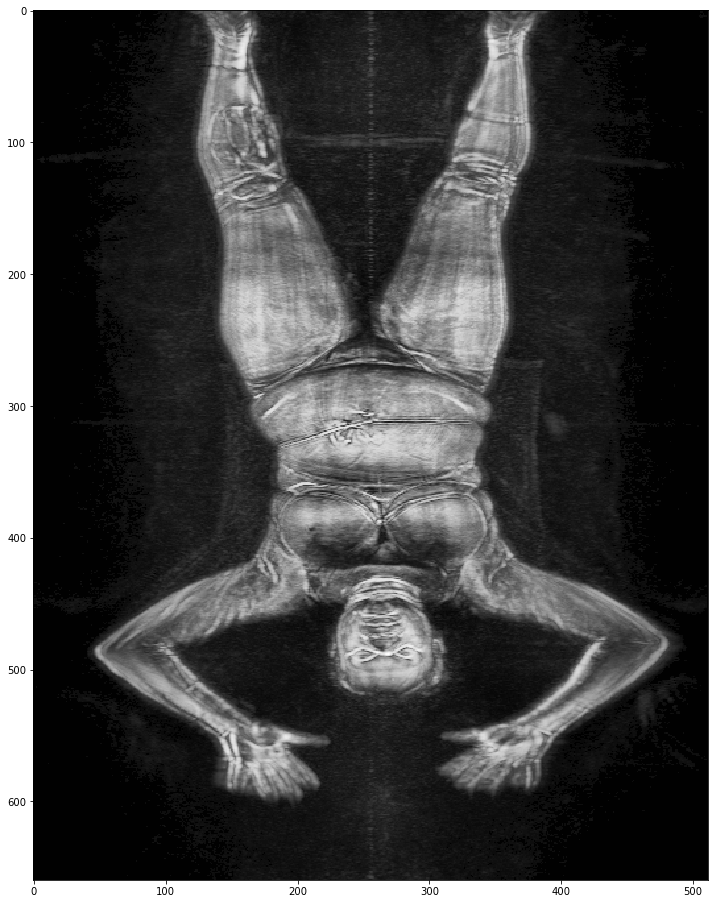

In [36]:
# %matplotlib inline
# import matplotlib.pyplot as plt

npdata = np.load(
    os.path.join(
        PREPROCESSED_DATA_FOLDER, 'preprocessed_TSA_scans-a3daps-01941f33fd090ae5df8c95992c027862.npy'))
# fix,ax = plt.subplots(4,4,figsize=(16,16))
# images = npdata[0]
# labels = npdata[1]
# for row in range(4):
#     for col in range(4):
#         ax[row,col].imshow(images[row*16 + col*4], cmap="gray")
fix,ax = plt.subplots(figsize=(16,16))
ax.imshow(images[0], cmap="gray")
print(labels)

<H3>Train and Test Split</H3>

The next function takes the full minibatch list and splits it between train and test sets, using the TRAIN_TEST_SPLIT_RATIO.  Note that as mentioned above building FILE_LIST searches through the minibatch file name and looks for the string '-tz' + THREAT_ZONE + '-' in the file name.  If you used the preprocessor above, it creates the files in that form.

In [7]:
#---------------------------------------------------------------------------------------
# get_train_test_file_list(): gets the batch file list, splits between train and test
#
# parameters:      none
#
# returns:         none
#
#-------------------------------------------------------------------------------------

def get_train_test_file_list():
    
    global FILE_LIST
    global TRAIN_SET_FILE_LIST
    global TEST_SET_FILE_LIST

    if os.listdir(PREPROCESSED_DATA_FOLDER) == []:
        print ('No preprocessed data available.  Skipping preprocessed data setup..')
    else:
        FILE_LIST = [f for f in os.listdir(PREPROCESSED_DATA_FOLDER) 
                     if re.search(re.compile('-tz' + str(THREAT_ZONE) + '-'), f)]
        train_test_split = len(FILE_LIST) - \
                           max(int(len(FILE_LIST)*TRAIN_TEST_SPLIT_RATIO),1)
        TRAIN_SET_FILE_LIST = FILE_LIST[:train_test_split]
        TEST_SET_FILE_LIST = FILE_LIST[train_test_split:]
        print('Train/Test Split -> {} file(s) of {} used for testing'.format( 
              len(FILE_LIST) - train_test_split, len(FILE_LIST)))
        
# unit test ----------------------------
get_train_test_file_list()
#print (

Train/Test Split -> 14 file(s) of 72 used for testing


<H3>Generating an Input Pipeline</H3>

The following function reads in a minibatch, extracts features and labels, and then returns the data in a form that can be easily streamed into a tensorfow feed dictionary, or as we will do below, as a feed dictionary to a TFLearn based CNN.

In [8]:
#---------------------------------------------------------------------------------------
# input_pipeline(filename, path): prepares a batch of features and labels for training
#
# parameters:      filename - the file to be batched into the model
#                  path - the folder where filename resides
#
# returns:         feature_batch - a batch of features to train or test on
#                  label_batch - a batch of labels related to the feature_batch
#
#---------------------------------------------------------------------------------------

def input_pipeline(filename, path):

    preprocessed_tz_scans = []
    feature_batch = []
    label_batch = []
    
    #Load a batch of preprocessed tz scans
    preprocessed_tz_scans = np.load(os.path.join(path, filename))
        
    #Shuffle to randomize for input into the model
    np.random.shuffle(preprocessed_tz_scans)
    
    # separate features and labels
    for example_list in preprocessed_tz_scans:
        for example in example_list:
            feature_batch.append(example[0])
            label_batch.append(example[1])
    
    feature_batch = np.asarray(feature_batch, dtype=np.float32)
    label_batch = np.asarray(label_batch, dtype=np.float32)
    
    return feature_batch, label_batch
  
# unit test ------------------------------------------------------------------------
#print ('Train Set -----------------------------')
#for f_in in TRAIN_SET_FILE_LIST:
#    feature_batch, label_batch = input_pipeline(f_in, PREPROCESSED_DATA_FOLDER)
#    print (' -> features shape {}:{}:{}'.format(len(feature_batch), 
#                                                len(feature_batch[0]), 
#                                                len(feature_batch[0][0])))
#    print (' -> labels shape   {}:{}'.format(len(label_batch), len(label_batch[0])))
    
#print ('Test Set -----------------------------')
#for f_in in TEST_SET_FILE_LIST:
#    feature_batch, label_batch = input_pipeline(f_in, PREPROCESSED_DATA_FOLDER)
#    print (' -> features shape {}:{}:{}'.format(len(feature_batch), 
#                                                len(feature_batch[0]), 
#                                                len(feature_batch[0][0])))
#    print (' -> labels shape   {}:{}'.format(len(label_batch), len(label_batch[0])))

<H3>Shuffling the Training Set</H3>

Below we use TFLearn, an abstraction of Tensorflow, to build the convnet. Using TFLearn we can set the fit operation to shuffle rows within a mini batch.  This function shuffles the minibatch list, so that in addition to intra-minibatch shuffling, the there is also  shuffling of the order the mini batches are fed to the model.

In [9]:
#---------------------------------------------------------------------------------------
# shuffle_train_set(): shuffle the list of batch files so that each train step
#                      receives them in a different order since the TRAIN_SET_FILE_LIST
#                      is a global
#
# parameters:      train_set - the file listing to be shuffled
#
# returns:         none
#
#-------------------------------------------------------------------------------------

def shuffle_train_set(train_set):
    sorted_file_list = random.shuffle(train_set)
    TRAIN_SET_FILE_LIST = sorted_file_list
    
# Unit test ---------------
#print ('Before Shuffling ->', TRAIN_SET_FILE_LIST)
#shuffle_train_set(TRAIN_SET_FILE_LIST)
#print ('After Shuffling ->', TRAIN_SET_FILE_LIST)

<H3>Defining the Alexnet CNN</H3>

The Alexnet was first put to the real world test during the ImageNet Large Scale Visual Recognition Challenge in 2012. The performance of this network was a quantum shift for its time as the model achieved a top-5 error of 15.3%, more than 10.8 percentage points ahead of the runner up.  The solution is elaborated in  [this paper by the original author](https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf) if you are interested in learning more. 

But in short the network consists of 7 layers, 5 convolutions/maxpools, plus 2 regression layers at the end.  The structure of the model looks like this: 

<img src="https://kratzert.github.io/images/finetune_alexnet/alexnet.png" width="700" height="600">

Using TFLearn makes this definition is quite intuitive and simple.  

In [10]:
#---------------------------------------------------------------------------------------
# alexnet(width, height, lr): defines the alexnet
#
# parameters:      width - width of the input image
#                  height - height of the input image
#                  lr - learning rate
#
# returns:         none
#
#-------------------------------------------------------------------------------------

def alexnet(width, height, lr):
    network = input_data(shape=[None, width, height, 1], name='features')
    network = conv_2d(network, 96, 11, strides=4, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 256, 5, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 256, 3, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='momentum', loss='categorical_crossentropy', 
                         learning_rate=lr, name='labels')

    model = tflearn.DNN(network, checkpoint_path=MODEL_PATH + MODEL_NAME, 
                        tensorboard_dir=TRAIN_PATH, tensorboard_verbose=3, max_checkpoints=1)

    return model

<H3>The Trainer</H3>

Finally, the trainer is straight forward.  Set up the network, loop to read in minibatches for test and train and run the fit method.  Note that TFLearn treats each "minibatch" as an epoch.  For the illustration purposes noted here, its not a big deal, but after may runs it may be quite annoying.  

Up until now, all the work I've personally done has been using the lower level interface.  This was my first time trying TFLearn.  I liked a lot about TFLearn.  Network construction is easy-peasy.  I haven't worked with Keras as of yet, but it looks like it may have a few advantages worth considering.

In [11]:
#---------------------------------------------------------------------------------------
# train_conv_net(): runs the train op
#
# parameters:      none
#
# returns:         none
#
#-------------------------------------------------------------------------------------

def train_conv_net():
    
    val_features = []
    val_labels = []
    
    # get train and test batches
    get_train_test_file_list()
    
    # instantiate model
    model = alexnet(IMAGE_DIM, IMAGE_DIM, LEARNING_RATE)
    
    # read in the validation test set
    for j, test_f_in in enumerate(TEST_SET_FILE_LIST):
        if j == 0:
            val_features, val_labels = input_pipeline(test_f_in, PREPROCESSED_DATA_FOLDER)
        else:
            tmp_feature_batch, tmp_label_batch = input_pipeline(test_f_in, 
                                                                PREPROCESSED_DATA_FOLDER)
            val_features = np.concatenate((tmp_feature_batch, val_features), axis=0)
            val_labels = np.concatenate((tmp_label_batch, val_labels), axis=0)

    val_features = val_features.reshape(-1, IMAGE_DIM, IMAGE_DIM, 1)

    
    
    # start training process
    for i in range(N_TRAIN_STEPS):

        # shuffle the train set files before each step
        shuffle_train_set(TRAIN_SET_FILE_LIST)
        
        # run through every batch in the training set
        for f_in in TRAIN_SET_FILE_LIST:
            
            # read in a batch of features and labels for training
            feature_batch, label_batch = input_pipeline(f_in, PREPROCESSED_DATA_FOLDER)
            feature_batch = feature_batch.reshape(-1, IMAGE_DIM, IMAGE_DIM, 1)
            #print ('Feature Batch Shape ->', feature_batch.shape)                
                
            # run the fit operation
            model.fit({'features': feature_batch}, {'labels': label_batch}, n_epoch=1, 
                      validation_set=({'features': val_features}, {'labels': val_labels}), 
                      shuffle=True, snapshot_step=None, show_metric=True, 
                      run_id=MODEL_NAME)
            
# unit test -----------------------------------
train_conv_net()

Training Step: 172  | total loss: 0.39685 | time: 15.598s
| Momentum | epoch: 058 | loss: 0.39685 - acc: 0.8738 -- iter: 128/176
Training Step: 173  | total loss: 0.40343 | time: 48.130s
| Momentum | epoch: 058 | loss: 0.40343 - acc: 0.8692 | val_loss: 0.36583 - val_acc: 0.8884 -- iter: 176/176
--


<H3>Wrap Up!</H3>

Alright, now its time to cut it loose.  I convert this notebook into a script and let the magic begin.  So far I have run training against the first three threat zones (1-3),  I am currently seeing validation accuracy in the 92-96% range. If you checked out the [EDA](http://s://www.kaggle.com/jbfarrar/exploratory-data-analysis-and-example-generation) you'll recall that the probabilities for the first three zones are 11.6%, 11%, 9.1% respectively.  So a model that just predicts "no contraband", should perform at 88.4%, 89%, and 90.8%.  So while it appears we may be getting some predictive value, much work would be needed to drive those accuracy numbers higher.  With the pipeline working, I'm going to fire up a meaningful training run andI will update this section with a fullsome view by threat zone of the accuracy, once I've run enough epochs to have useful view.

If you've found this helpful, I hope you'll give me an up vote!

Good Luck!

